<span style = "color:blue; font-size:24px">ARIMAModel2024Data</span>

This notebook only focuses on ARIMA model training.

ZeekData24 Attack Profiles
Dataset 1: Multiple Attack Types
Dataset 2: Multiple Attack Types
Dataset 3: Multiple Attack Types
Dataset 4: Multiple Attack Types
Dataset 5: Multiple Attack Types
Datest 6: Benign Data
Dataset 7: Benign Data

<span style = "color:blue; font-size:24px">Preprocessing for ARIMA Model</span>

In [1]:
# Spark imports
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Python imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

# Initialize Spark session
spark = SparkSession.builder.config("SPARK_LOCAL_IP", "192.168.1.2") \
                            .appName("Pre-Preprocess Mission Log") \
                            .master("spark://192.168.1.2:7077") \
                            .config("spark.driver.cores", "2") \
                            .config("spark.driver.memory", "10g") \
                            .config("spark.executor.memory", "12g") \
                            .config("spark.executor.cores", "3") \
                            .config("spark.dynamicAllocation.shuffleTracking.enabled", "true") \
                            .config("spark.dynamicAllocation.enabled", "true") \
                            .config("spark.dynamicAllocation.minExecutors", "5") \
                            .config("spark.dynamicAllocation.maxExecutors", "8") \
                            .config("spark.executor.instances", "5") \
                            .getOrCreate()

#Paths containing network data
data_paths = [
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-02-25 - 2024-03-03/part-00000-8b838a85-76eb-4896-a0b6-2fc425e828c2-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-03 - 2024-03-10/part-00000-0955ed97-8460-41bd-872a-7375a7f0207e-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-10 - 2024-03-17/part-00000-071774ae-97f3-4f31-9700-8bfcdf41305a-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-17 - 2024-03-24/part-00000-5f556208-a1fc-40a1-9cc2-a4e24c76aeb3-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-24 - 2024-03-31/part-00000-ea3a47a3-0973-4d6b-a3a2-8dd441ee7901-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-10-27 - 2024-11-03/part-00000-69700ccb-c1c1-4763-beb7-cd0f1a61c268-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-11-03 - 2024-11-10/part-00000-f078acc1-ab56-40a6-a6e1-99d780645c57-c000.snappy.parquet"
            ]
# Predefined list of MITRE ATT&CK labels
mitre_labels = [
    "Privilege Escalation", "Execution", "Persistence", "Defense Evasion",
    "Credential Access", "Discovery", "Lateral Movement", "Collection",
    "Exfiltration", "Command and Control", "Impact", "Reconnaissance", "Resource Development"
]

# Container to hold the processed DataFrames
df_list = []

# Counter variable
j = 0

# Loop through each path, load and process the data
for path in data_paths:
    # Load each dataset
    df = spark.read.parquet(path)
   
    # Select relevant columns
    df = df.select("ts", "duration", "orig_bytes", "resp_bytes", "orig_ip_bytes", "resp_ip_bytes", "label_tactic")
   
    #Show all rows of attack labels before any preprocessing
    print(f"Dataset {j+1}: All rows of 'label_tactic' before preprocessing:")
    all_label_tactics = df.select("label_tactic").distinct().collect()
    for row in all_label_tactics:
        print(row['label_tactic'])
              
    # Handle missing values
    df = df.fillna({
        "duration": 0,
        "orig_bytes": 0,
        "resp_bytes": 0,
        "orig_ip_bytes": 0,
        "resp_ip_bytes": 0,
        "label_tactic": "none"  # Default to 'none'
    })

    # Print unique count for each tactic type
    print(f"Dataset {j+1}: Unique count for each 'label_tactic' value before conversion")
    unique_tactic_counts = df.groupBy("label_tactic").count().orderBy(F.desc("count"))
    unique_tactic_counts.show(truncate=False)
   
    # Convert 'label_tactic' to binary: 'none' -> 0, anything else -> 1
    df = df.withColumn("label_tactic_binary", F.when(F.col("label_tactic") == "none", 0).otherwise(1))

    # Show the first few rows after binary conversion to verify
    print(f"First few rows after binary encoding:")
    df.select("label_tactic", "label_tactic_binary").show(5, truncate=False)

    # Convert 'label_tactic' to list of attack types for encoding
    df = df.withColumn("label_tactic_split", F.split("label_tactic", ","))
   
    # Perform MultiLabel encoding (before aggregation)
    df = df.withColumn("label_tactic_binary_encoded", F.expr(
        "array(" + ",".join([f"IF(array_contains(label_tactic_split, '{label}'), 1, 0)" for label in mitre_labels]) + ")"
    ))

    # Show the first few rows of 'label_tactic_binary_encoded' to check encoding
    print(f"First few rows of 'label_tactic_binary_encoded' (encoded attack types):")
    df.select("label_tactic", "label_tactic_split", "label_tactic_binary_encoded").show(5, truncate=False)

    #Time window 
    # Convert 'ts' to a timestamp
    df = df.withColumn("ts", F.from_unixtime("ts").cast("timestamp"))
   
    # Aggregate data within time windows
    window_size = "1 seconds"
    stride = "0 minutes"  # Remove overlap
    
    df_agg = df.groupBy(F.window("ts", window_size)) \
        .agg(
            F.sum("orig_bytes").alias("sum_orig_bytes"),
            F.sum("resp_bytes").alias("sum_resp_bytes"),
            F.sum("orig_ip_bytes").alias("sum_orig_ip_bytes"),
            F.sum("resp_ip_bytes").alias("sum_resp_ip_bytes"),
            F.count("*").alias("connection_count"),
            F.max("label_tactic_binary").alias("label_tactic_binary_agg"),
            F.collect_set("label_tactic_split").alias("label_tactic_split_agg"),
            F.max("label_tactic_binary_encoded").alias("label_tactic_binary_encoded_agg")
        )

    # Flatten the window structure
    df_agg_flat = df_agg.select(
        F.col("window.start").alias("window_start"),
        F.col("window.end").alias("window_end"),
        "sum_orig_bytes",
        "sum_resp_bytes",
        "sum_orig_ip_bytes",
        "sum_resp_ip_bytes",
        "connection_count",
        "label_tactic_binary_agg",
        "label_tactic_split_agg",
        "label_tactic_binary_encoded_agg"
    )

    # Sort by window start time
    df_agg_sorted = df_agg_flat.orderBy("window_start")
   
    # Convert Spark DataFrame to Pandas for further analysis
    df_pandas_sorted = df_agg_sorted.toPandas()

    # Log-transform only (no normalization)
    df_pandas_sorted["sum_orig_bytes_log"] = np.log1p(df_pandas_sorted["sum_orig_bytes"])

    # Print the number of rows
    print(f"DataFrame for: {path} has total rows: {len(df_pandas_sorted)}")

    # Print unique 'label_tactic_split_agg' values
    print(f"Dataset {j+1}: Unique 'label_tactic_split_agg' values")
    unique_label_tactic_agg = df_agg_sorted.select("label_tactic_split_agg").distinct().collect()
    for row in unique_label_tactic_agg:
        print(row['label_tactic_split_agg'])

    # Add to DataFrame List
    df_list.append(df_pandas_sorted)

    #Indicate data finished loading
    print(f"Dataset {j+1} loaded successfully")

    j += 1

25/01/28 12:10:05 WARN Utils: Your hostname, ubuntu-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.1.112 instead (on interface ens33)
25/01/28 12:10:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/28 12:10:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/28 12:10:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/01/28 12:10:07 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/01/28 12:10:07 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


Dataset 1: All rows of 'label_tactic' before preprocessing:


Privilege Escalation
Reconnaissance
Credential Access
Persistence
Initial Access
Exfiltration
Defense Evasion
Dataset 1: Unique count for each 'label_tactic' value before conversion


+--------------------+------+
|label_tactic        |count |
+--------------------+------+
|Credential Access   |236706|
|Reconnaissance      |12762 |
|Initial Access      |2172  |
|Privilege Escalation|1251  |
|Persistence         |1251  |
|Defense Evasion     |1251  |
|Exfiltration        |50    |
+--------------------+------+

First few rows after binary encoding:
+--------------------+-------------------+
|label_tactic        |label_tactic_binary|
+--------------------+-------------------+
|Defense Evasion     |1                  |
|Initial Access      |1                  |
|Persistence         |1                  |
|Privilege Escalation|1                  |
|Defense Evasion     |1                  |
+--------------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+--------------------+----------------------+---------------------------------------+
|label_tactic        |label_tactic_split    |label_tactic_bin

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-02-25 - 2024-03-03/part-00000-8b838a85-76eb-4896-a0b6-2fc425e828c2-c000.snappy.parquet has total rows: 17995
Dataset 1: Unique 'label_tactic_split_agg' values


[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Credential Access']]
[['Reconnaissance'], ['Initial Access']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation'], ['Credential Access']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Privilege Escalation']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Credential Access'], ['Privilege Escalation']]
[['Initial Access'], ['Credential Access']]
[['Reconnaissance']]
[['Credential Access']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation']]
[['Persistence'], ['Defense Evasion'], ['In

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-03 - 2024-03-10/part-00000-0955ed97-8460-41bd-872a-7375a7f0207e-c000.snappy.parquet has total rows: 3554
Dataset 2: Unique 'label_tactic_split_agg' values


[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Credential Access']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Privilege Escalation']]
[['Initial Access'], ['Credential Access']]
[['Reconnaissance']]
[['Credential Access']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Privilege Escalation']]
[['Initial Access']]
[['Reconnaissance'], ['Initial Access'], ['Credential Access']]
Dataset 2 loaded successfully
Dataset 3: All rows of 'label_tactic' before preprocessing:
Privilege Escalation
Reconnaissance
Credential Access
Persistence
Initial Access
Exfiltration
Defense Evasion
Dataset 3: Unique count for each 'label_tactic' value befo

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-10 - 2024-03-17/part-00000-071774ae-97f3-4f31-9700-8bfcdf41305a-c000.snappy.parquet has total rows: 12366
Dataset 3: Unique 'label_tactic_split_agg' values


[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Credential Access']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Privilege Escalation'], ['Credential Access']]
[['Reconnaissance'], ['Initial Access']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation'], ['Credential Access']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Privilege Escalation']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Credential Access'], ['Privilege Escalation']]
[['Initial Access'], ['Credential Access']]
[['Reconn

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-17 - 2024-03-24/part-00000-5f556208-a1fc-40a1-9cc2-a4e24c76aeb3-c000.snappy.parquet has total rows: 27523
Dataset 4: Unique 'label_tactic_split_agg' values


[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Credential Access']]
[['Reconnaissance'], ['Initial Access']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation'], ['Credential Access']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Privilege Escalation']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Credential Access'], ['Privilege Escalation']]
[['Initial Access'], ['Credential Access']]
[['Reconnaissance']]
[['Cre

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-24 - 2024-03-31/part-00000-ea3a47a3-0973-4d6b-a3a2-8dd441ee7901-c000.snappy.parquet has total rows: 7474
Dataset 5: Unique 'label_tactic_split_agg' values


[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Credential Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Credential Access']]
[['Reconnaissance'], ['Initial Access']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation'], ['Credential Access']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Privilege Escalation']]
[['Reconnaissance'], ['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Privilege Escalation']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Credential Access'], ['Privilege Escalation']]
[['Initial Access'], ['Credential Access']]
[['Reconnaissance']]
[['Credential Access']]
[['Persistence'], ['Defense Evasion'], ['Initial Access'], ['Exfiltration'], ['Privilege Escalation'], ['Credential Access']]
[[

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-10-27 - 2024-11-03/part-00000-69700ccb-c1c1-4763-beb7-cd0f1a61c268-c000.snappy.parquet has total rows: 98456
Dataset 6: Unique 'label_tactic_split_agg' values


[['none']]
Dataset 6 loaded successfully
Dataset 7: All rows of 'label_tactic' before preprocessing:
none
Dataset 7: Unique count for each 'label_tactic' value before conversion
+------------+------+
|label_tactic|count |
+------------+------+
|none        |503263|
+------------+------+

First few rows after binary encoding:
+------------+-------------------+
|label_tactic|label_tactic_binary|
+------------+-------------------+
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
+------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+------------+------------------+---------------------------------------+
|label_tactic|label_tactic_split|label_tactic_binary_encoded            |
+------------+------------------+---------------------------------------+
|none        |[none]            |[0, 0,

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-11-03 - 2024-11-10/part-00000-f078acc1-ab56-40a6-a6e1-99d780645c57-c000.snappy.parquet has total rows: 107369
Dataset 7: Unique 'label_tactic_split_agg' values


[['none']]
Dataset 7 loaded successfully


In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



--- Dataset 1 Visualization and Insights ---

Basic Statistics:
                        window_start                     window_end  \
count                          17995                          17995   
mean   2024-02-29 15:25:17.172603648  2024-02-29 15:25:18.172603648   
min              2024-02-27 22:00:37            2024-02-27 22:00:38   
25%       2024-02-28 17:21:34.500000     2024-02-28 17:21:35.500000   
50%              2024-02-29 13:03:58            2024-02-29 13:03:59   
75%       2024-03-01 12:39:11.500000     2024-03-01 12:39:12.500000   
max              2024-03-02 17:59:59            2024-03-02 18:00:00   
std                              NaN                            NaN   

       sum_orig_bytes  sum_resp_bytes  sum_orig_ip_bytes  sum_resp_ip_bytes  \
count    17995.000000    17995.000000       17995.000000       1.799500e+04   
mean     11722.560267   184113.996777       78281.300139       7.768757e+05   
min          0.000000        0.000000          40.000000  

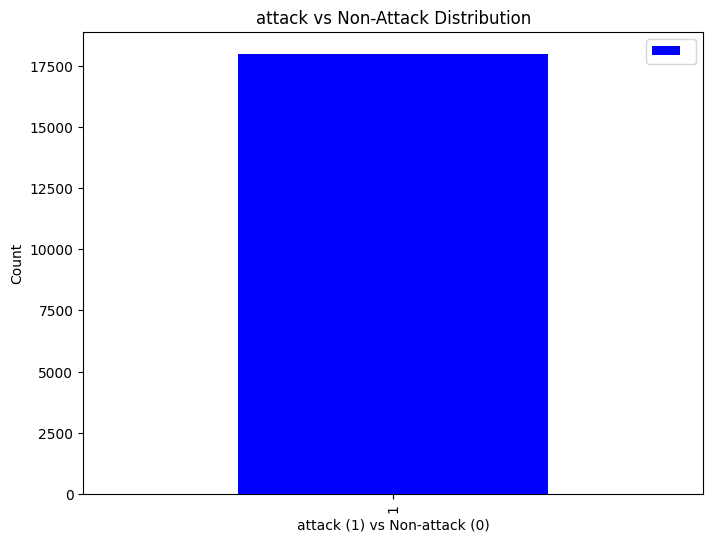

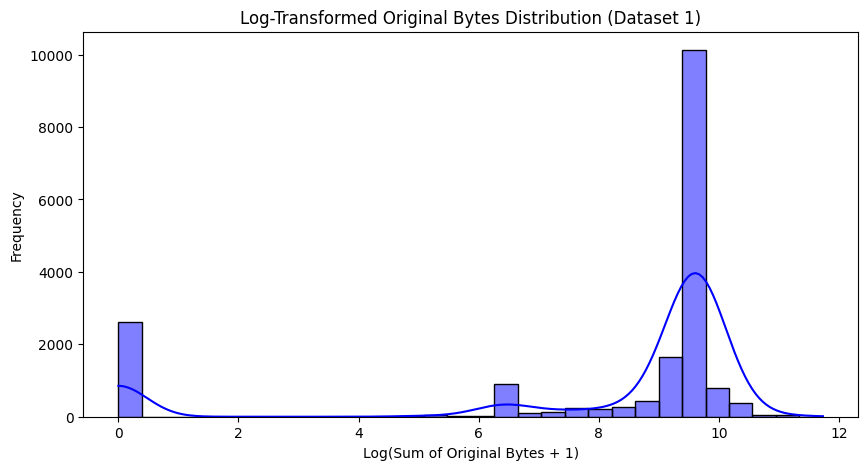

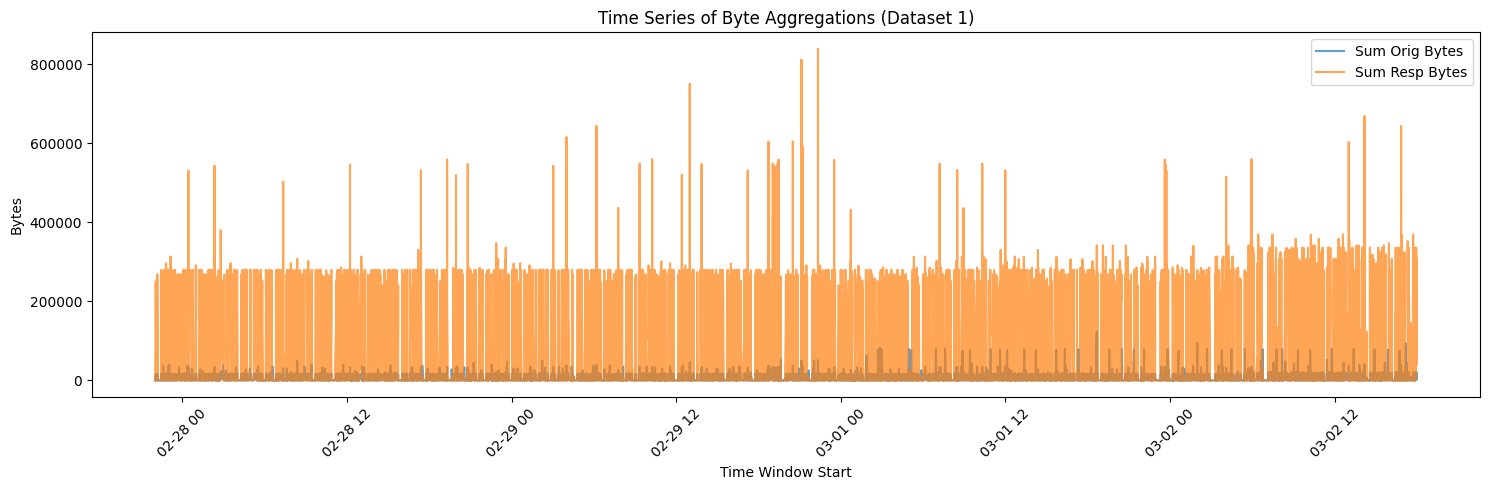

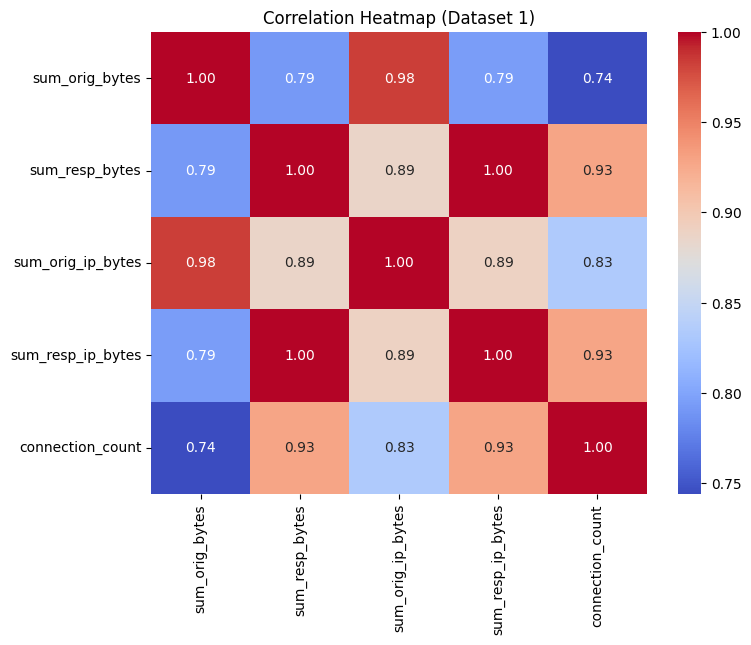


--- Dataset 2 Visualization and Insights ---

Basic Statistics:
                        window_start                     window_end  \
count                           3554                           3554   
mean   2024-03-03 06:00:23.390264576  2024-03-03 06:00:24.390264320   
min              2024-03-02 18:00:00            2024-03-02 18:00:01   
25%    2024-03-03 00:01:11.249999872  2024-03-03 00:01:12.249999872   
50%       2024-03-03 06:11:58.500000     2024-03-03 06:11:59.500000   
75%    2024-03-03 12:01:28.750000128  2024-03-03 12:01:29.750000128   
max              2024-03-03 17:59:41            2024-03-03 17:59:42   
std                              NaN                            NaN   

       sum_orig_bytes  sum_resp_bytes  sum_orig_ip_bytes  sum_resp_ip_bytes  \
count     3554.000000     3554.000000        3554.000000       3.554000e+03   
mean     11715.241418   181822.820484       79437.716376       7.673233e+05   
min          0.000000        0.000000          40.000000  

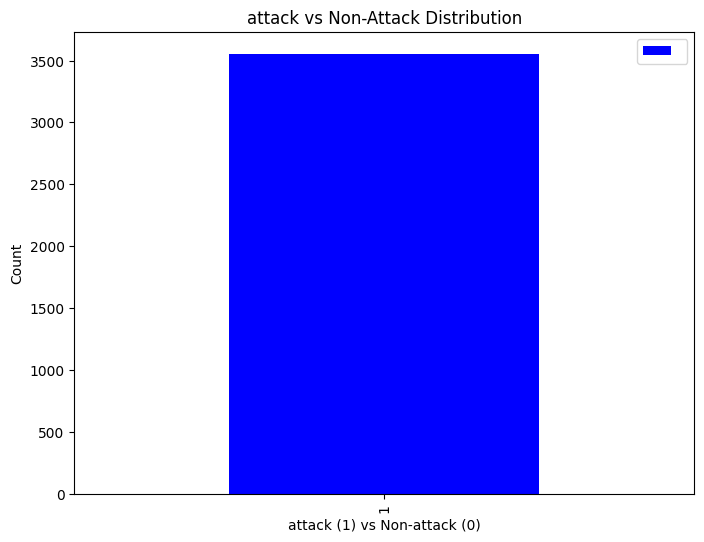

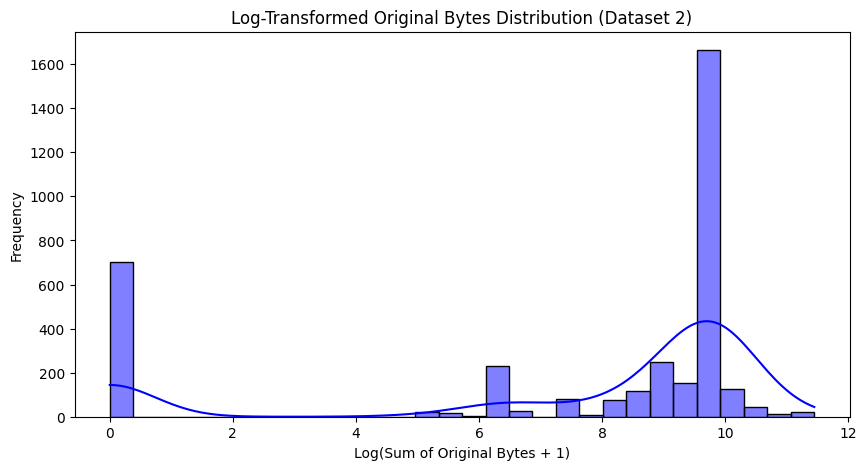

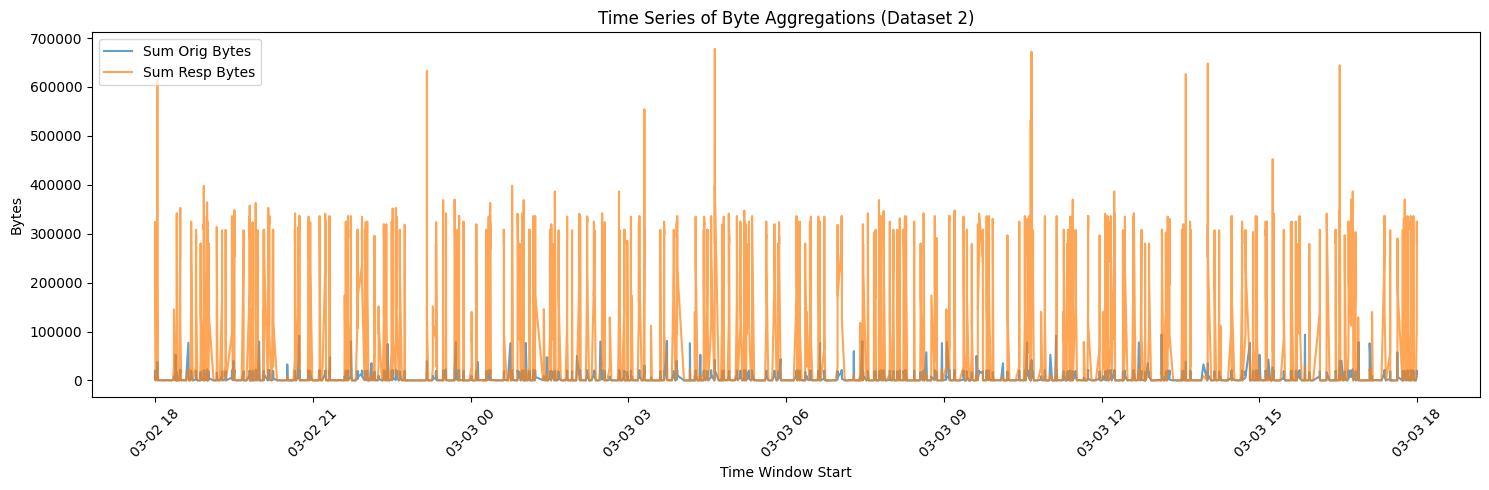

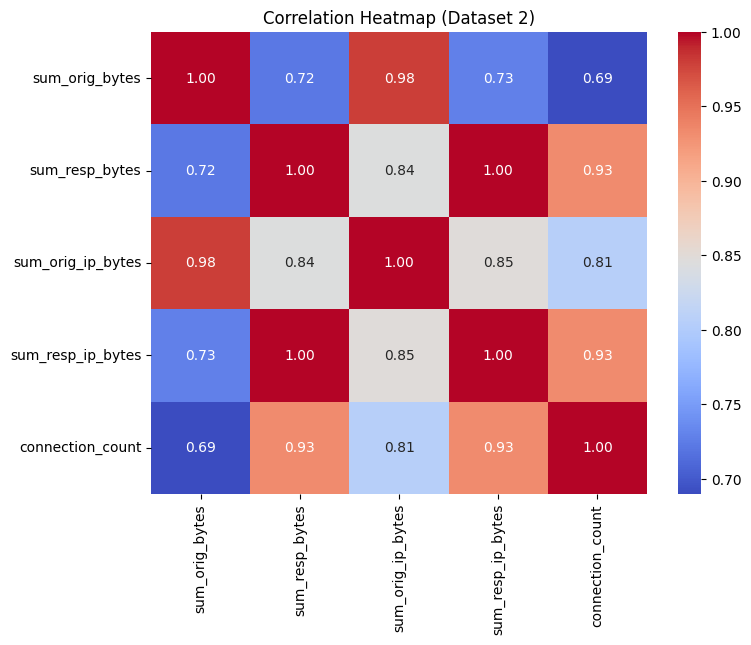


--- Dataset 3 Visualization and Insights ---

Basic Statistics:
                        window_start                     window_end  \
count                          12366                          12366   
mean   2024-03-15 05:29:26.722707712  2024-03-15 05:29:27.722707712   
min              2024-03-13 16:04:09            2024-03-13 16:04:10   
25%    2024-03-14 10:37:49.249999872  2024-03-14 10:37:50.249999872   
50%       2024-03-15 05:29:56.500000     2024-03-15 05:29:57.500000   
75%    2024-03-16 00:14:06.750000128  2024-03-16 00:14:07.750000128   
max              2024-03-16 18:58:15            2024-03-16 18:58:16   
std                              NaN                            NaN   

       sum_orig_bytes  sum_resp_bytes  sum_orig_ip_bytes  sum_resp_ip_bytes  \
count    12366.000000    12366.000000       12366.000000       1.236600e+04   
mean     11239.577551   172923.340450       75005.876435       7.298852e+05   
min          0.000000        0.000000          40.000000  

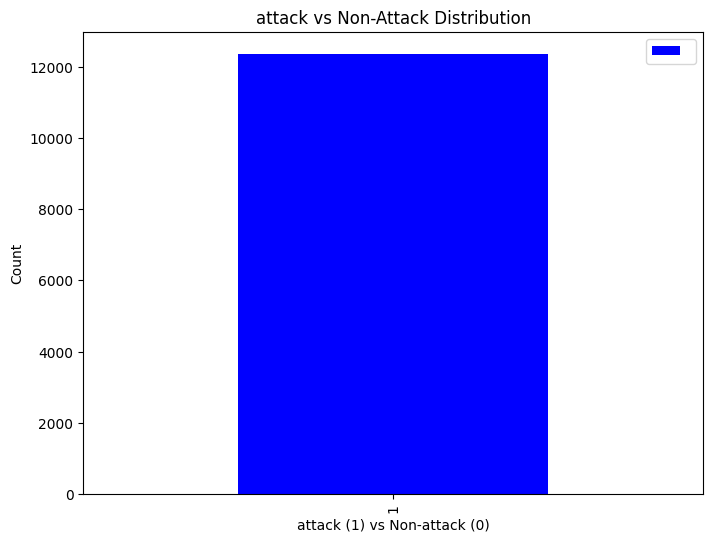

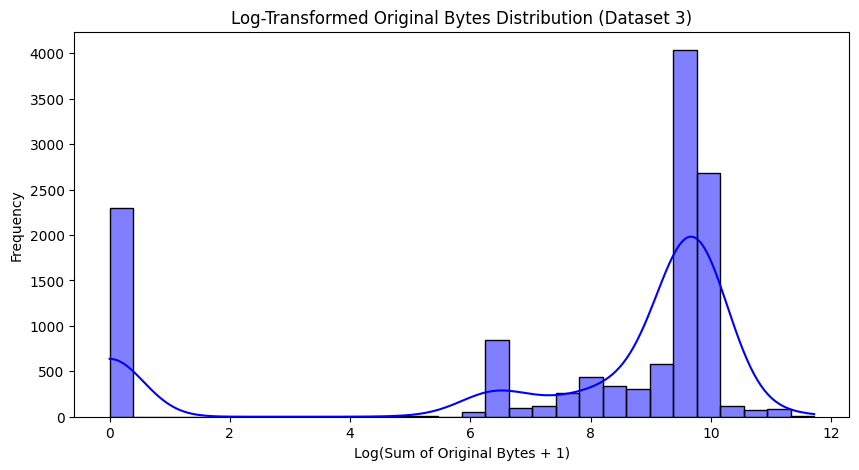

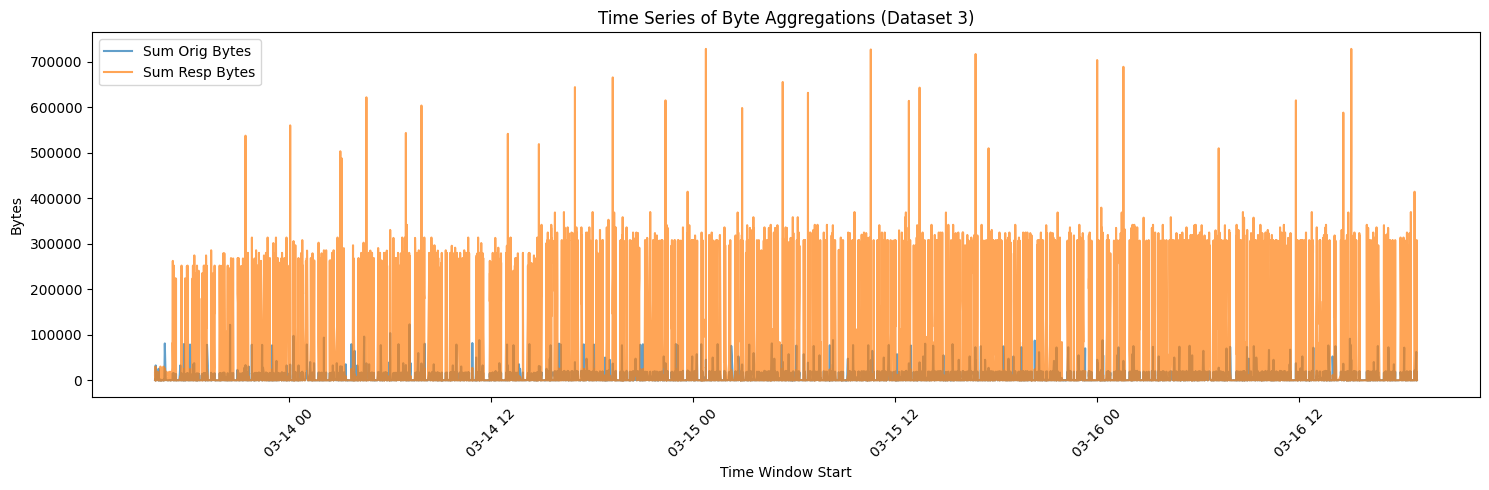

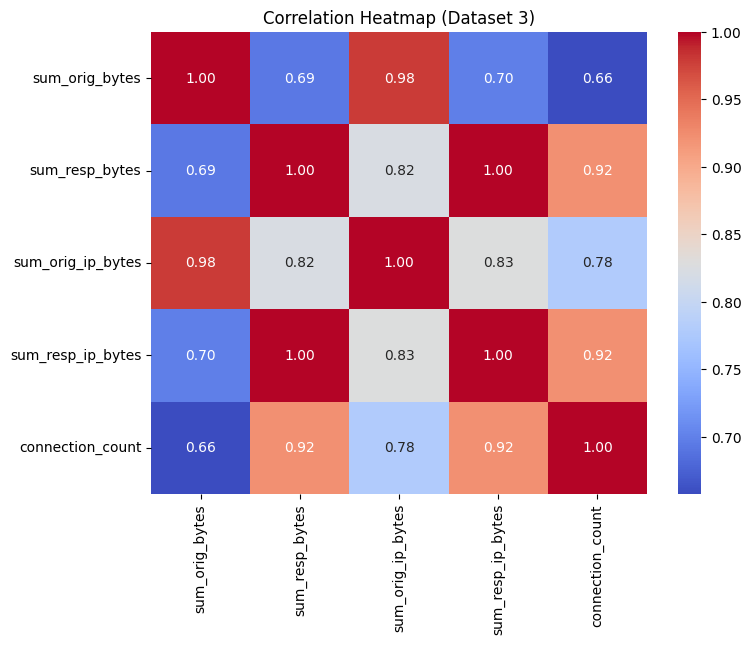


--- Dataset 4 Visualization and Insights ---

Basic Statistics:
                        window_start                     window_end  \
count                          27523                          27523   
mean   2024-03-20 07:06:18.091887104  2024-03-20 07:06:19.091886592   
min              2024-03-16 19:02:36            2024-03-16 19:02:37   
25%       2024-03-18 13:31:49.500000     2024-03-18 13:31:50.500000   
50%              2024-03-20 07:08:06            2024-03-20 07:08:07   
75%       2024-03-22 01:08:03.500000     2024-03-22 01:08:04.500000   
max              2024-03-23 18:59:38            2024-03-23 18:59:39   
std                              NaN                            NaN   

       sum_orig_bytes  sum_resp_bytes  sum_orig_ip_bytes  sum_resp_ip_bytes  \
count    27523.000000    2.752300e+04       27523.000000       2.752300e+04   
mean     11361.468190    1.760325e+05       76190.868583       7.429672e+05   
min          0.000000    0.000000e+00          40.000000  

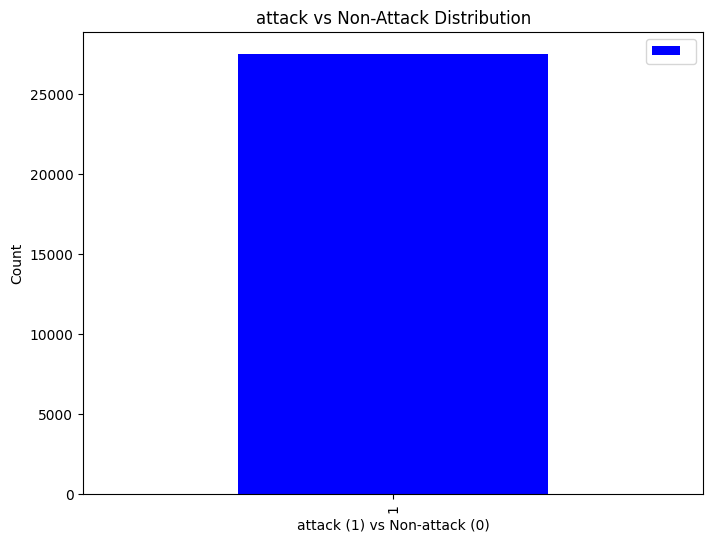

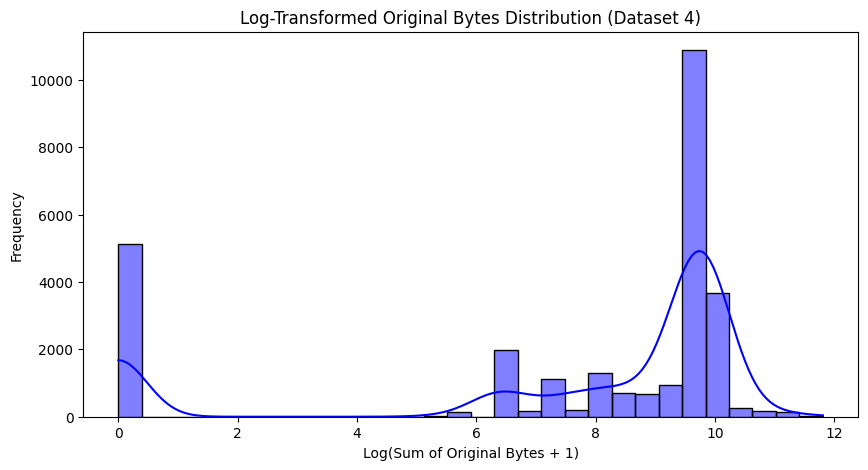

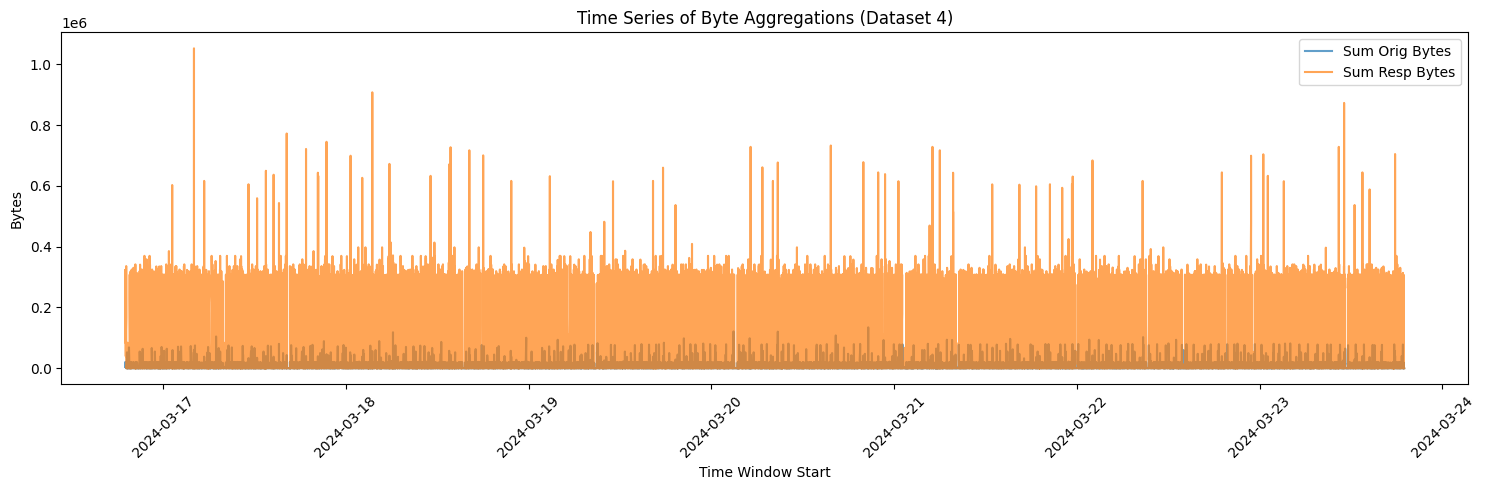

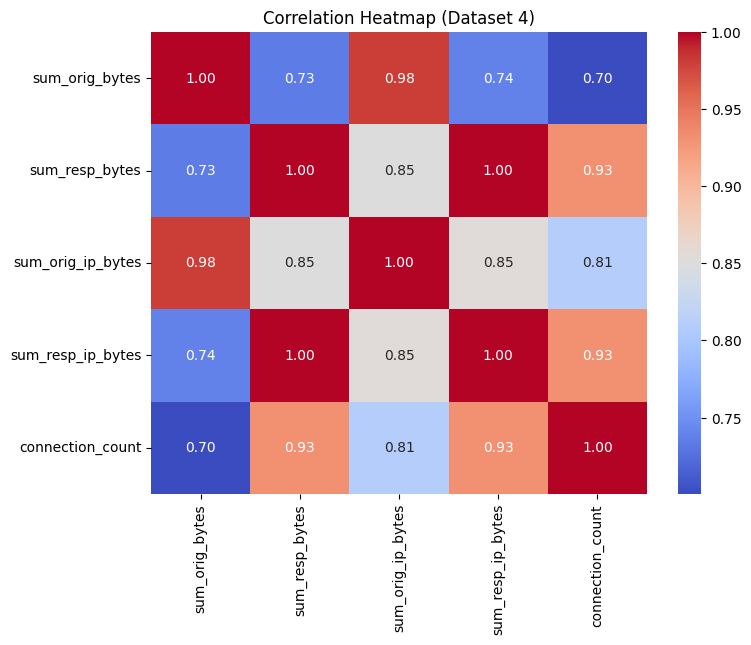


--- Dataset 5 Visualization and Insights ---

Basic Statistics:
                        window_start                     window_end  \
count                           7474                           7474   
mean   2024-03-25 17:09:29.448755712  2024-03-25 17:09:30.448755712   
min              2024-03-23 19:01:21            2024-03-23 19:01:22   
25%    2024-03-24 06:29:11.249999872  2024-03-24 06:29:12.249999872   
50%              2024-03-24 17:41:32            2024-03-24 17:41:33   
75%    2024-03-27 06:14:18.750000128  2024-03-27 06:14:19.750000128   
max              2024-03-27 18:59:45            2024-03-27 18:59:46   
std                              NaN                            NaN   

       sum_orig_bytes  sum_resp_bytes  sum_orig_ip_bytes  sum_resp_ip_bytes  \
count     7474.000000     7474.000000        7474.000000       7.474000e+03   
mean     11559.565828   182315.524619       77756.369815       7.692665e+05   
min          0.000000        0.000000          40.000000  

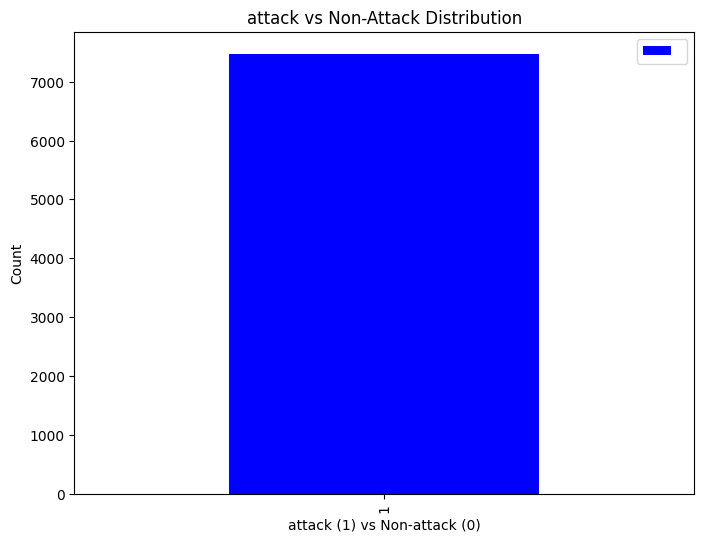

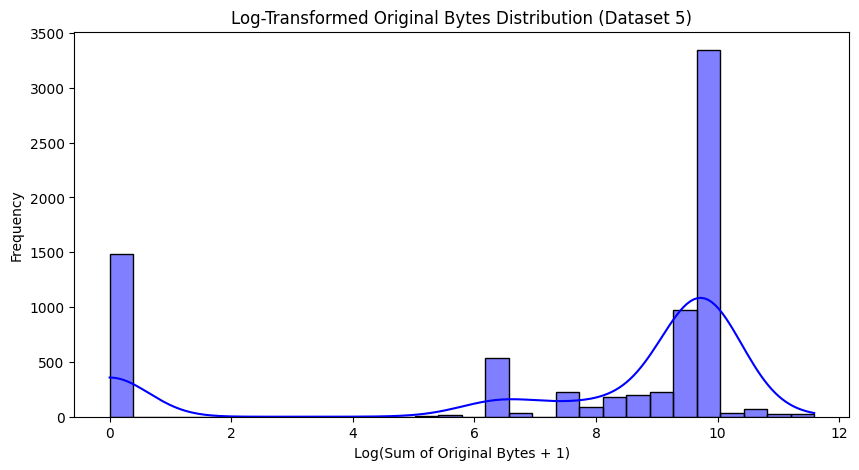

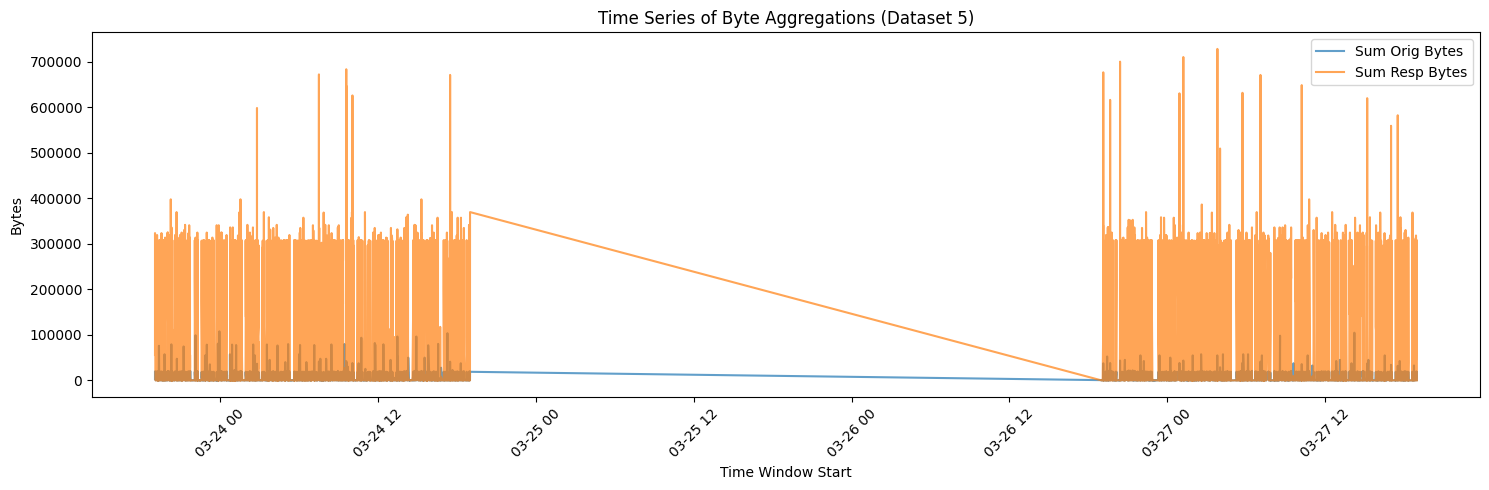

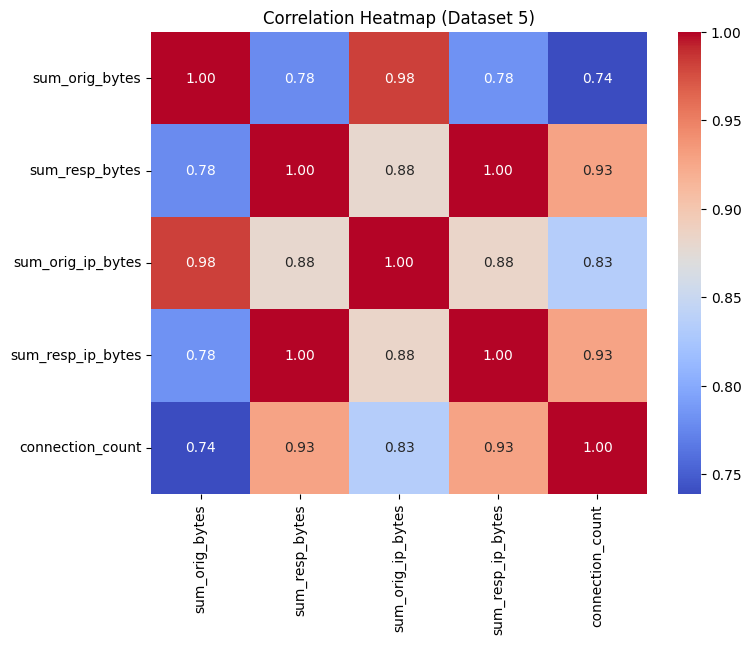


--- Dataset 6 Visualization and Insights ---

Basic Statistics:
                        window_start                     window_end  \
count                          98456                          98456   
mean   2024-11-01 10:28:32.213507072  2024-11-01 10:28:33.213506560   
min              2024-10-31 02:00:00            2024-10-31 02:00:01   
25%       2024-10-31 18:13:08.500000     2024-10-31 18:13:09.500000   
50%       2024-11-01 10:29:08.500000     2024-11-01 10:29:09.500000   
75%    2024-11-02 02:41:07.249999872  2024-11-02 02:41:08.249999872   
max              2024-11-02 18:59:58            2024-11-02 18:59:59   
std                              NaN                            NaN   

       sum_orig_bytes  sum_resp_bytes  sum_orig_ip_bytes  sum_resp_ip_bytes  \
count    98456.000000    98456.000000       98456.000000       98456.000000   
mean       346.527058      243.918928         643.449348         389.073068   
min          0.000000        0.000000          40.000000  

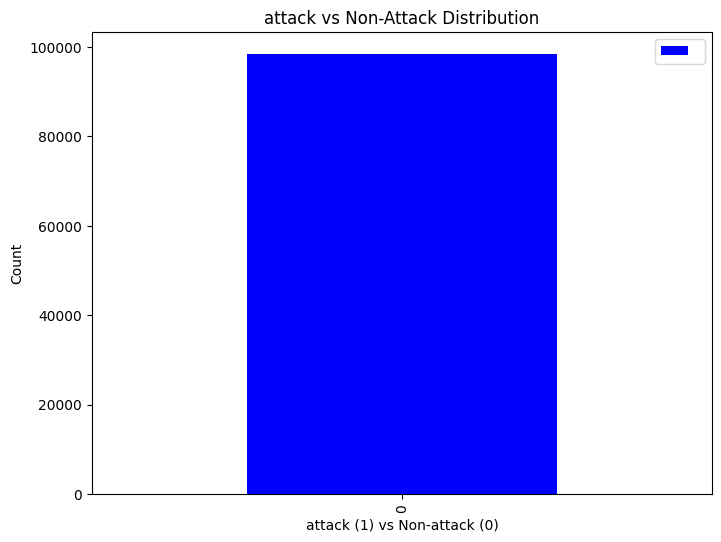

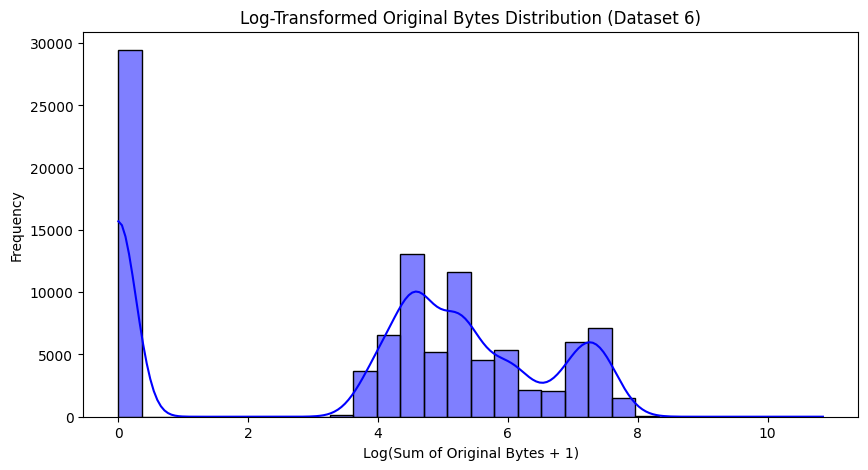

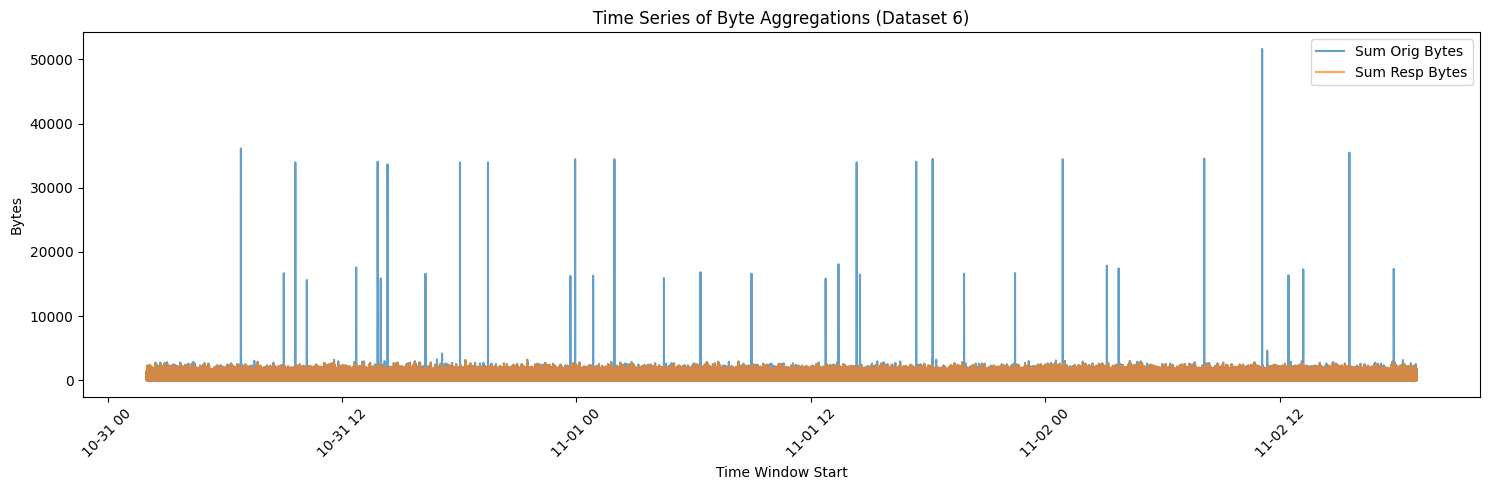

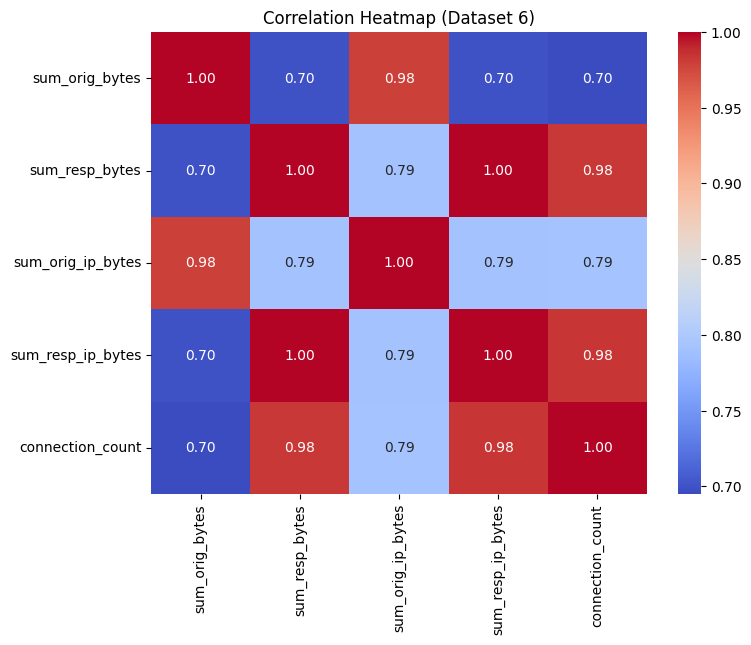


--- Dataset 7 Visualization and Insights ---

Basic Statistics:
                        window_start                     window_end  \
count                         107369                         107369   
mean   2024-11-04 06:09:35.161377792  2024-11-04 06:09:36.161377792   
min              2024-11-02 19:00:00            2024-11-02 19:00:01   
25%              2024-11-03 12:12:58            2024-11-03 12:12:59   
50%              2024-11-04 06:00:08            2024-11-04 06:00:09   
75%              2024-11-05 00:00:00            2024-11-05 00:00:01   
max              2024-11-05 17:59:48            2024-11-05 17:59:49   
std                              NaN                            NaN   

       sum_orig_bytes  sum_resp_bytes  sum_orig_ip_bytes  sum_resp_ip_bytes  \
count   107369.000000   107369.000000      107369.000000      107369.000000   
mean       350.051821      247.396753         652.356527         394.707430   
min          0.000000        0.000000          40.000000  

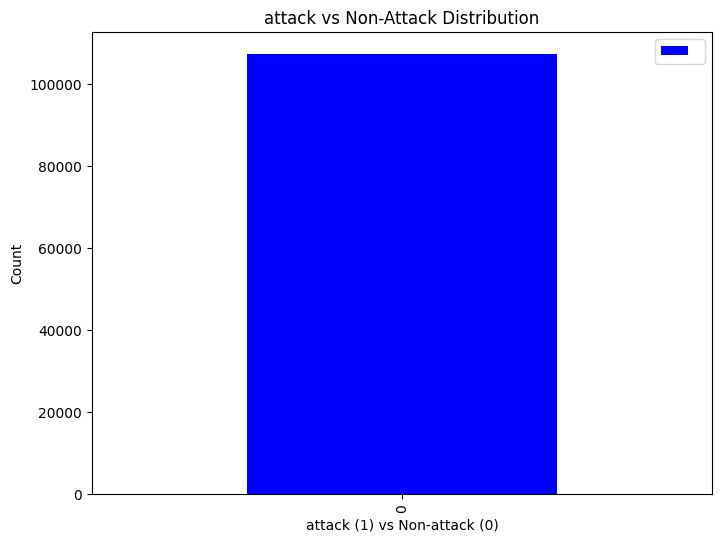

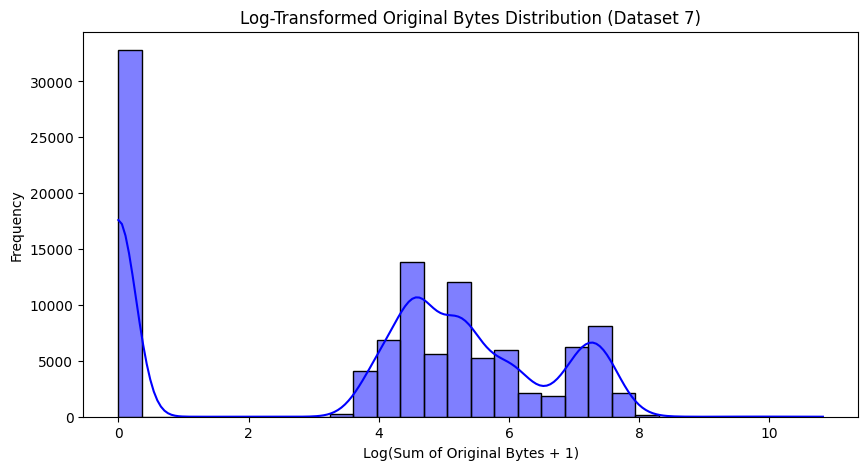

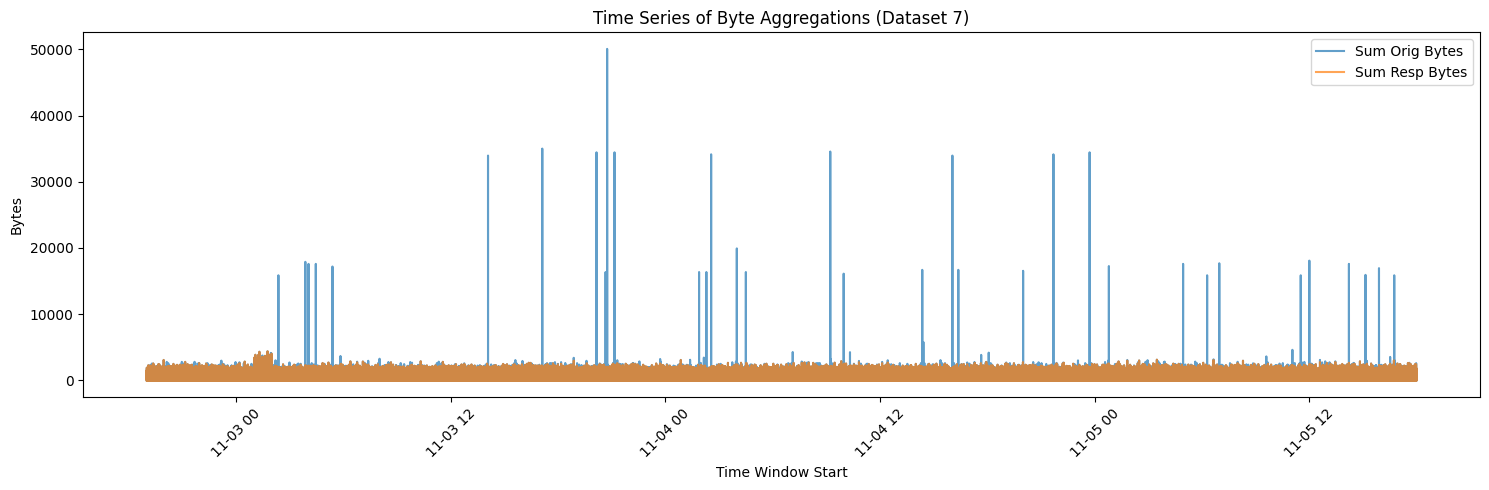

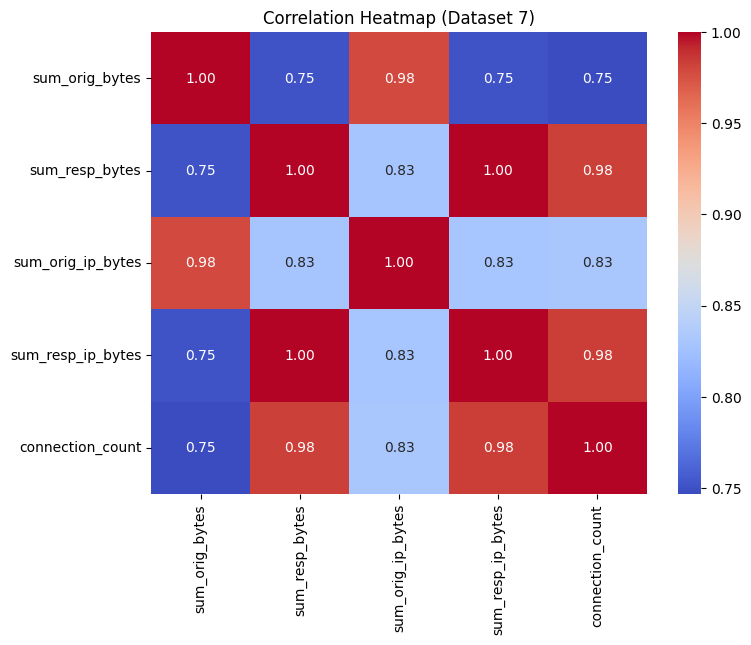

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Helper function for visualization
def visualize_data(df_list):
    for i, df in enumerate(df_list):
        print(f"\n--- Dataset {i+1} Visualization and Insights ---\n")

        # Display basic statistics
        print("Basic Statistics:")
        print(df.describe())

        # Plot the distribution of attack and non-attack connections
        '''plt.figure(figsize=(10, 5))
        sns.countplot(x=df["label_tactic_binary_agg"].astype(int), palette="Set2")
        plt.title(f"Attack vs Non-Attack Distribution (Dataset {i+1})")
        plt.xlabel("Attack Label (0: Non-Attack, 1: Attack)")
        plt.ylabel("Count")
        plt.xticks([0, 1], ["Non-Attack", "Attack"])
        plt.tight_layout()
        plt.show()'''

        attack_distribution = df.groupby("label_tactic_binary_agg").size()
        attack_distribution.plot(kind="bar", figsize=(8,6), color=["blue", "red"], legend=True)
        plt.title("attack vs Non-Attack Distribution")
        plt.xlabel("attack (1) vs Non-attack (0)")
        plt.ylabel("Count")
        plt.show()

        # Plot log-transformed byte sums for better visibility of skewed data
        plt.figure(figsize=(10, 5))
        sns.histplot(df["sum_orig_bytes_log"], kde=True, bins=30, color="blue")
        plt.title(f"Log-Transformed Original Bytes Distribution (Dataset {i+1})")
        plt.xlabel("Log(Sum of Original Bytes + 1)")
        plt.ylabel("Frequency")
        plt.show()

        # Plot aggregated data over time
        plt.figure(figsize=(15, 5))
        plt.plot(pd.to_datetime(df["window_start"]), df["sum_orig_bytes"], label="Sum Orig Bytes", alpha=0.7)
        plt.plot(pd.to_datetime(df["window_start"]), df["sum_resp_bytes"], label="Sum Resp Bytes", alpha=0.7)
        plt.legend()
        plt.title(f"Time Series of Byte Aggregations (Dataset {i+1})")
        plt.xlabel("Time Window Start")
        plt.ylabel("Bytes")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Correlation heatmap
        correlation_matrix = df[[
            "sum_orig_bytes",
            "sum_resp_bytes",
            "sum_orig_ip_bytes",
            "sum_resp_ip_bytes",
            "connection_count"
        ]].corr()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title(f"Correlation Heatmap (Dataset {i+1})")
        plt.show()
"""
        print(df["label_tactic_split_agg"].head())
        #Convert lists in 'label_tactic_split_agg' to tuples
        df["label_tactic_split_agg"]=df["label_tactic_split_agg"].apply(lambda x: tuple(x) if isinstance(x, list)else x) 
        # Unique aggregated attack labels
        unique_agg_labels = df["label_tactic_split_agg"].dropna().unique()
        print(f"Unique Aggregated Attack Labels: {unique_agg_labels}")
        for label in unique_agg_labels:
            print(label)

        print(f"\nFinished visualization for Dataset {i+1}\n")
"""
# Call the function on the loaded dataframes
visualize_data(df_list)


<span style = "color:blue; font-size:24px">Train ARIMA Model</span>

In [4]:
pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Take dataset 7 (attack only data) and use it to train
df_train_sample = df_list[6]

# Check for Stationarity Using Augmented Dickey-Fuller (ADF) Test on the sampled data
result = adfuller(df_train_sample['sum_orig_bytes_log'].dropna())

# Extract and print test statistics
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values: ')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the result
if result[1] < 0.05:
    print(f"The time series for the sampled dataset is stationary (reject H0)")
else:
    print(f"The time series for the sampled dataset is non-stationary (fail to reject H0)")

# Check for seasonality and plot ACF for the sampled data
seasonal_list = []  # 1 for seasonal, 0 for non-seasonal
seasonal_periods = []  # Record the seasonal period (m)

# Plot the original time series for the sampled data
plt.figure(figsize=(10,6))
plt.plot(df_train_sample['sum_orig_bytes_log'], label='Sum of Originator Bytes')
plt.title('Time Series Plot (Checking for Seasonality) - Sampled Dataset')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.show()

# Calculate the maximum number of lags based on data length
max_lags = min(50, len(df_train_sample['sum_orig_bytes_log']) - 1)  # Ensure we don't exceed the data length
acf_values = acf(df_train_sample['sum_orig_bytes_log'], nlags=max_lags)

# Threshold for significance (1.96/sqrt(N), where N is the number of observations)
threshold = 1.96 / (len(df_train_sample['sum_orig_bytes_log']) ** 0.5)

# Identify significant lags
significant_lags = [lag for lag, value in enumerate(acf_values) if abs(value) > threshold]

# Determine if the dataset is seasonal
seasonal = False
seasonal_period = None

for j in range(1, len(significant_lags)):
    # Calculate the gap between significant lags
    lag_gap = significant_lags[j] - significant_lags[j-1]
    if lag_gap > 1:  # Avoid immediate autocorrelations
        seasonal = True
        seasonal_period = lag_gap
        break

# Record results for the sampled dataset
if seasonal:
    print(f"The sampled time series shows evidence of seasonality with a period of {seasonal_period}.")
    seasonal_list.append(1)
    seasonal_periods.append(seasonal_period)
else:
    print(f"The sampled time series does not show significant evidence of seasonality.")
    seasonal_list.append(0)
    seasonal_periods.append(None)  # No seasonality detected

# Plot the ACF for visual purposes
plt.figure(figsize=(10, 6))
plot_acf(df_train_sample['sum_orig_bytes_log'], lags=max_lags)
plt.title("ACF Plot for Sampled Dataset")
plt.show()

# Print the seasonal periods found for reference
print("Seasonal periods detected:", seasonal_periods)

# Define lists for p, d, q
p_list = []
d_list = []
q_list = []

# Check if the seasonal period is not None before fitting the ARIMA model
seasonal_period = seasonal_periods[0] if seasonal_list[0] == 1 else None

if seasonal_period is not None:
    print("Fitting auto_arima with seasonality...")

    try:
        # Fit auto_arima to find optimal p, d, q values based on seasonality
        auto_model = auto_arima(df_train_sample['sum_orig_bytes_log'],
                                start_p=0, max_p=14,  # Range for p
                                start_q=0, max_q=5,   # Range for q
                                d=None,                # Let auto_arima determine d
                                seasonal=True,         # Seasonality is detected
                                m=seasonal_period,     # Use the seasonal period found
                                trace=True,            # Output the process
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)

        # Print the summary of the best model found
        print("Summary for Sampled Dataset:")
        print(auto_model.summary())

        # Get the best values of p, d, and q
        p, d, q = auto_model.order

        p_list.append(p)
        d_list.append(d)
        q_list.append(q)
    except Exception as e:
        print(f"An error occurred while fitting auto_arima for the sampled dataset: {e}")
else:
    print("No seasonality detected. Fitting auto_arima without seasonality...")

    try:
        # Fit auto_arima to find optimal p, d, q values for non-seasonal data
        auto_model = auto_arima(df_train_sample['sum_orig_bytes_log'],
                                start_p=0, max_p=14,  # Range for p
                                start_q=0, max_q=5,   # Range for q
                                d=None,                # Let auto_arima determine d
                                seasonal=False,        # No seasonality detected
                                trace=True,            # Output the process
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)

        # Print the summary of the best model found
        print("Summary for Sampled Dataset:")
        print(auto_model.summary())

        # Get the best values of p, d, and q
        p, d, q = auto_model.order

        p_list.append(p)
        d_list.append(d)
        q_list.append(q)
    except Exception as e:
        print(f"An error occurred while fitting auto_arima for the sampled dataset: {e}")

# After training the ARIMA model, you can use the fitted model to make forecasts
try:
    model = auto_arima(df_train_sample['sum_orig_bytes_log'],
                       p=p_list[0], d=d_list[0], q=q_list[0],
                       seasonal=True if seasonal_list[0] == 1 else False,
                       m=seasonal_periods[0] if seasonal_list[0] == 1 else None,
                       trace=True, error_action='ignore', suppress_warnings=True)

    # Forecasting the next steps (adjust the forecast horizon as needed)
    forecast_steps = 10  # Example, forecast for 10 steps ahead
    forecast = model.predict(n_periods=forecast_steps)

    print(f"Forecast for Sampled Dataset:")
    print(forecast)
except Exception as e:
    print(f"An error occurred during forecasting for the sampled dataset: {e}")